#### Read weather data, analyse it and send to Node-RED


In [2]:
#This this a notebook with python code

In [11]:
import os
import pickle
import time
from collections import namedtuple
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import calendar
import json

In [13]:
#You can execute unic commands
!ls -l /

total 44
lrwxrwxrwx   1 root root    7 Dec  4  2018 bin -> usr/bin
drwxr-xr-x   5 root root  360 Apr 23 18:29 dev
drwxr-xr-x   1 root root 4096 Apr 23 18:29 etc
drwxr-xr-x   1 root root 4096 Apr 23 18:29 home
lrwxrwxrwx   1 root root    7 Dec  4  2018 lib -> usr/lib
lrwxrwxrwx   1 root root    9 Dec  4  2018 lib64 -> usr/lib64
drwxr-xr-x   2 root root 4096 Apr 11  2018 media
drwxr-xr-x   2 root root 4096 Apr 11  2018 mnt
drwxr-xr-x   1 root root 4096 Apr 14 06:21 opt
dr-xr-xr-x 881 root root    0 Apr 23 18:29 proc
dr-xr-x---   1 root root 4096 Apr 14 06:13 root
drwxr-xr-x   1 root root 4096 Mar 23 12:58 run
lrwxrwxrwx   1 root root    8 Dec  4  2018 sbin -> usr/sbin
drwxr-xr-x   2 root root 4096 Apr 11  2018 srv
dr-xr-xr-x  13 root root    0 Apr 22 23:57 sys
drwxrwx---   1 root root 4096 Apr 14 06:21 tmp
drwxr-xr-x   1 root root 4096 Dec  4  2018 usr
drwxr-xr-x   1 root root 4096 Apr 23 18:29 var


# Load Some Data

In [26]:
import pandas as pd
import io
import requests


#IEDINBUR6_weather.csv.zip

url="https://github.com/markusvankempen/ThinkLab1239/blob/master/data/IBERLINB54_weather.csv.zip?raw=true"
#s=requests.get(url).content

station ="IBERLINB54"
data_raw=pd.read_csv(url, compression='zip')
data_raw.head()

Unnamed: 0                 Time  TemperatureC  DewpointC  PressurehPa  \
0           0  2015-01-01 00:00:00           4.6        4.2       1030.7   
1           1  2015-01-01 00:05:00           4.7        4.2       1030.7   
2           2  2015-01-01 00:10:00           4.7        4.2       1030.7   
3           3  2015-01-01 00:15:00           4.7        4.2       1030.7   
4           4  2015-01-01 00:20:00           4.7        4.2       1030.7   

  WindDirection  WindDirectionDegrees  WindSpeedKMH  WindSpeedGustKMH  \
0            SW                   233           4.8               4.8   
1         North                  -999           0.0               4.8   
2            SW                   220           3.2               4.8   
3         North                  -999           0.0               0.0   
4         North                  -999           0.0               0.0   

   Humidity  HourlyPrecipMM  Conditions  Clouds  dailyrainMM SoftwareType  \
0        97             0.0         NaN     NaN          0.0  weewx-2.7.0   
1        97             0.0         NaN     NaN          0.0  weewx-2.7.0   
2        97             0.0         NaN     NaN          0.0  weewx-2.7.0   
3        97             0.0         NaN     NaN          0.0  weewx-2.7.0   
4        97             0.0         NaN     NaN          0.0  weewx-2.7.0   

               DateUTC     station  
0  2014-12-31 23:00:00  IBERLINB54  
1  2014-12-31 23:05:00  IBERLINB54  
2  2014-12-31 23:10:00  IBERLINB54  
3  2014-12-31 23:15:00  IBERLINB54  
4  2014-12-31 23:20:00  IBERLINB54

In [16]:
# Transform 
# Pick out the data we need
#
# Give the variables some friendlier names and convert types as necessary.
data_raw['temp'] = data_raw['TemperatureC'].astype(float)
data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
data_raw['total_rain'] = data_raw['dailyrainMM'].astype(float)
#data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
data_raw['humidity'] = data_raw['Humidity'].astype(float)
data_raw['wind_direction'] = data_raw['WindDirectionDegrees']
data_raw['wind']   = data_raw['WindSpeedKMH']

# Extract out only the data we need.

data = data_raw.filter(['DateUTC', 'station','temp', 'rain', 'total_rain', 'humidity', 'wind'])#data = data[(data['date'] >= datetime(2015,1,1)) & (data['date'] <= datetime(2015,12,31))]
#data = data.set_index('datetime',drop=True)
data['datetime'] = pd.to_datetime(data['DateUTC'])
data['DateUTC'] = pd.to_datetime(data['DateUTC'])
data = data.set_index('datetime',drop=True)
data.index.name = 'index'
data.head()


DateUTC     station  temp  rain  total_rain  \
index                                                                         
2014-12-31 23:00:00 2014-12-31 23:00:00  IBERLINB54   4.6   0.0         0.0   
2014-12-31 23:05:00 2014-12-31 23:05:00  IBERLINB54   4.7   0.0         0.0   
2014-12-31 23:10:00 2014-12-31 23:10:00  IBERLINB54   4.7   0.0         0.0   
2014-12-31 23:15:00 2014-12-31 23:15:00  IBERLINB54   4.7   0.0         0.0   
2014-12-31 23:20:00 2014-12-31 23:20:00  IBERLINB54   4.7   0.0         0.0   

                     humidity  wind  
index                                
2014-12-31 23:00:00      97.0   4.8  
2014-12-31 23:05:00      97.0   0.0  
2014-12-31 23:10:00      97.0   3.2  
2014-12-31 23:15:00      97.0   0.0  
2014-12-31 23:20:00      97.0   0.0

index
2014-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-01-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-02-28    AxesSubplot(0.125,0.125;0.775x0.755)
2015-03-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-04-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-05-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-06-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-09-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-10-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-11-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: M, Name: temp, dtype: object

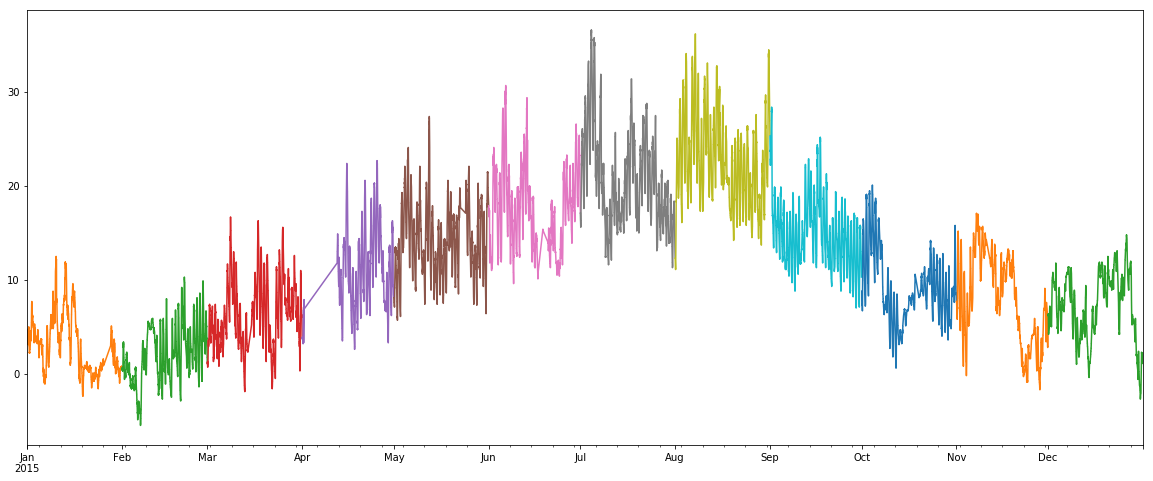

In [14]:
#Lets have a peek at the data 
#You will see there is an issue - Try to zoom in on it
#data.index = pd.to_datetime(data.index, unit='M')
plt.figure(figsize=(20,8))
#zoom=data["date":"date"]
data["temp"].resample("m").plot()  # compressing the data to monthly 
#data["2015-04-01":"2015-04-30"].head() 

index
2014-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-01-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-02-28    AxesSubplot(0.125,0.125;0.775x0.755)
2015-03-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-04-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-05-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-06-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-09-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-10-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-11-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: M, Name: rain, dtype: object

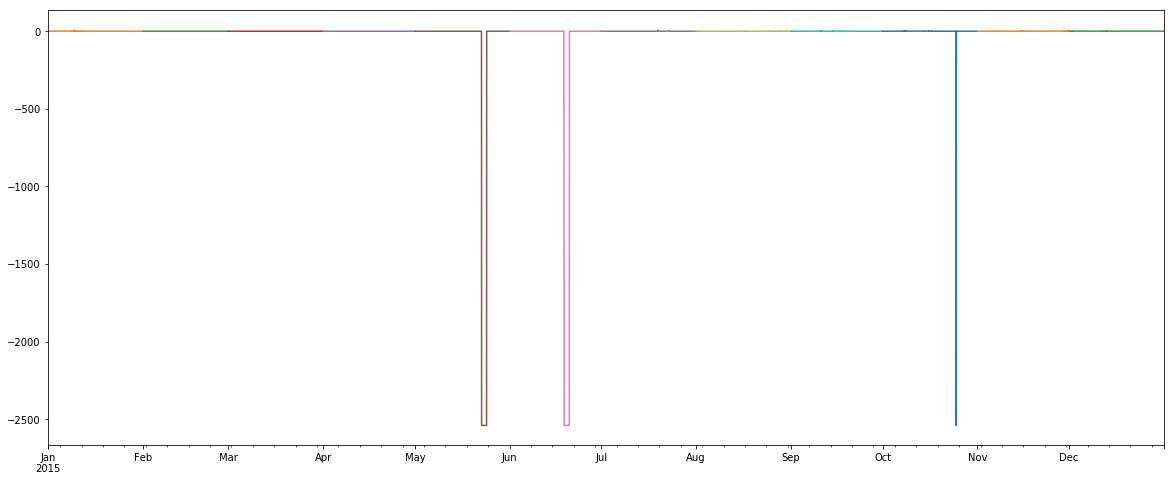

In [18]:
# Have a peek at the ran data
plt.figure(figsize=(20,8))
data['rain'].resample("m").plot()

index
2014-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-01-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-02-28    AxesSubplot(0.125,0.125;0.775x0.755)
2015-03-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-04-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-05-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-06-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-09-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-10-31    AxesSubplot(0.125,0.125;0.775x0.755)
2015-11-30    AxesSubplot(0.125,0.125;0.775x0.755)
2015-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: M, Name: rain, dtype: object

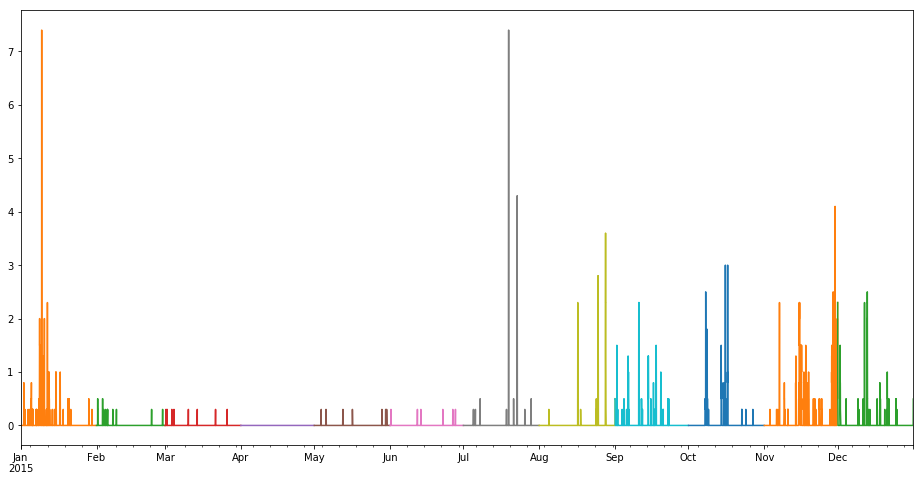

In [22]:

# There's an issue with some stations that record rainfall ~-2500 where data is missing.
if (data['rain'] < -500).sum() > 10:
    print("There's more than 10 messed up days - fixing")
    print(" in Station {}".format(station))
# remove the bad samples
    data = data[data['rain'] > -500]

#
plt.figure(figsize=(16,8))
data['rain'].resample("m").plot()

In [19]:
# get Rainy days
# If there's any rain at all, mark that!
data['raining'] = data['rain'] > 0.0
#Add some coloums
data['day'] = data['DateUTC'].apply(lambda x: x.date())
data['month'] = data['day'].apply(lambda x: x.month)
data["month_name"] = data['month'].apply(lambda x: calendar.month_abbr[x])
data.head()


DateUTC     station  temp  rain  total_rain  \
index                                                                         
2014-12-31 23:00:00 2014-12-31 23:00:00  IBERLINB54   4.6   0.0         0.0   
2014-12-31 23:05:00 2014-12-31 23:05:00  IBERLINB54   4.7   0.0         0.0   
2014-12-31 23:10:00 2014-12-31 23:10:00  IBERLINB54   4.7   0.0         0.0   
2014-12-31 23:15:00 2014-12-31 23:15:00  IBERLINB54   4.7   0.0         0.0   
2014-12-31 23:20:00 2014-12-31 23:20:00  IBERLINB54   4.7   0.0         0.0   

                     humidity  wind  raining         day  month month_name  
index                                                                       
2014-12-31 23:00:00      97.0   4.8    False  2014-12-31     12        Dec  
2014-12-31 23:05:00      97.0   0.0    False  2014-12-31     12        Dec  
2014-12-31 23:10:00      97.0   3.2    False  2014-12-31     12        Dec  
2014-12-31 23:15:00      97.0   0.0    False  2014-12-31     12        Dec  
2014-12-31 23:20:00      97.0   0.0    False  2014-12-31     12        Dec

March Rainy or Sunny days ? = 23
Days in the year =366


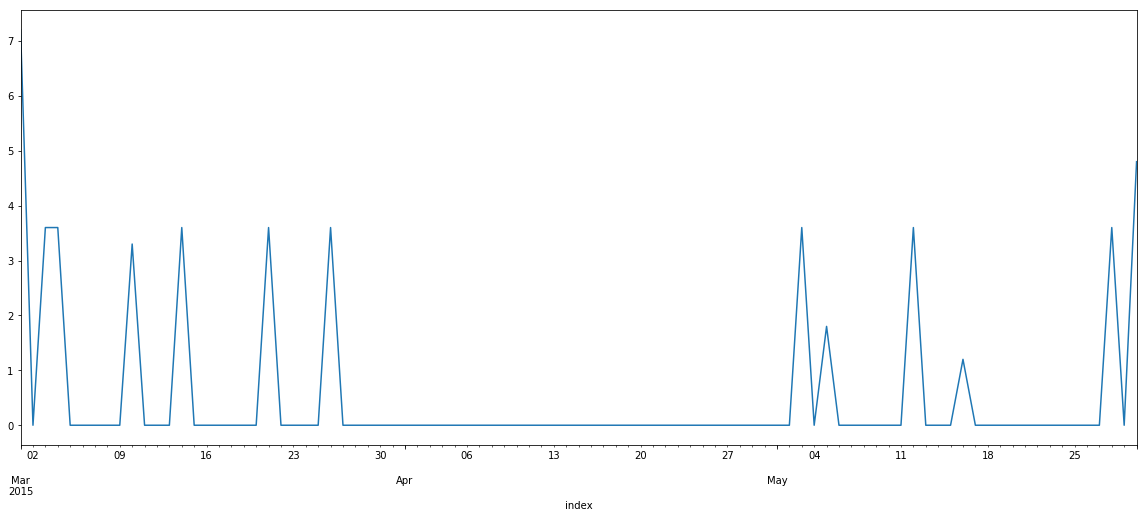

In [23]:
#Consitentcy Check
#
# Check if all the month have rainy days
#
testd = data["rain"].resample("D").sum()

#testd=testd['2015-04-01':'2015-04-30'].fillna(0)
#testd['2015-04-01':'2015-04-30'].apply(lambda x: x == False).sum() 
print("March Rainy or Sunny days ? = " +str(testd['2015-03-01':'2015-03-30'].apply(lambda x: x == 0).sum()))

testd['2015-03-01':'2015-03-30'].head(10)
plt.figure(figsize=(20,8))
testd['2015-03-01':'2015-05-30'].plot()


print("Days in the year ="+str(len(data["temp"].resample("D").sum())))  #Days 365 ???
#data1=data['2015-01-01':'2015-12-31']
#print("Days in the year ="+str(len(data1["temp"].resample("D").sum())))  #Days 365 ???

In [24]:
# Create final compressed data set for NR

mysdata=data.groupby('day')['raining'].any()
mysdata=pd.DataFrame(mysdata).reset_index()
mysdata['month'] = mysdata['day'].apply(lambda x: x.month)

mysdata=pd.DataFrame(mysdata.groupby('month')['raining'].value_counts())

mysdata.columns = ['Days']
mysdata.reset_index(inplace = True)
mysdata.columns = ['month', 'Rainy', 'Days']
mysdata.replace({"Rainy": {True: "Wet", False:"Dry"}}, inplace=True)
mysdata["month_name"] = mysdata['month'].apply(lambda x: calendar.month_abbr[x])


# Fix April adding zero rainy days
mysdata.loc[6] = [4,'Dry',30,'Apr'] 
mysdata.loc[-1] = [4,'Wet',0,'Apr']  # adding a row

mysdata = mysdata.sort_values(['month', 'Rainy'])
mysdata.reset_index(inplace = True)
del mysdata['index']
mysdata.head(24)



month Rainy  Days month_name
0       1   Dry    10        Jan
1       1   Wet    20        Jan
2       2   Dry    19        Feb
3       2   Wet     9        Feb
4       3   Dry    24        Mar
5       3   Wet     7        Mar
6       4   Dry    30        Apr
7       4   Wet     0        Apr
8       5   Dry    24        May
9       5   Wet     6        May
10      6   Dry    23        Jun
11      6   Wet     6        Jun
12      7   Dry    22        Jul
13      7   Wet     9        Jul
14      8   Dry    24        Aug
15      8   Wet     7        Aug
16      9   Dry    14        Sep
17      9   Wet    16        Sep
18     10   Dry    21        Oct
19     10   Wet    10        Oct
20     11   Dry    11        Nov
21     11   Wet    19        Nov
22     12   Dry    17        Dec
23     12   Wet    15        Dec

Text(0.5, 1.0, 'Wet or Dry Commuting in IBERLINB54')

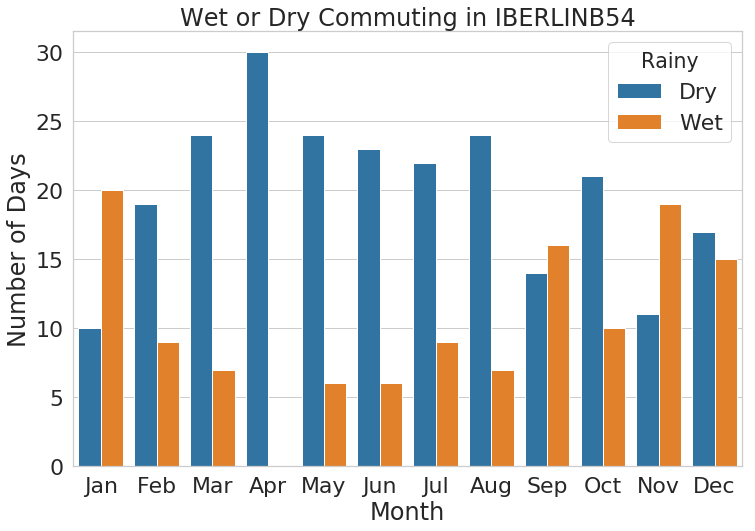

In [27]:
#Print the Final data set

import matplotlib.pyplot as plt
import seaborn as sns
# Monthly plot of rainy days
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.barplot(x="month_name", y="Days", hue="Rainy", data=mysdata.sort_values(['month', 'Rainy']))
plt.xlabel("Month")
plt.ylabel("Number of Days")
plt.title("Wet or Dry Commuting in {}".format(station))


In [13]:
# play ground 
getInfo = mysdata.sort_values(['month', 'Rainy']).loc[mysdata['month_name'] == 'Apr'].to_json()

#getInfo = getInfo1.loc[getInfo1['month_name'] == 'Feb'].to_json()

#getInfo['month']=""

mvk=json.loads(getInfo)
mvk["cmd"]="getInfo"
del mvk["month"]
mvk
#getInfo1


{'Rainy': {'6': 'Dry', '7': 'Wet'},
 'Days': {'6': 30, '7': 0},
 'month_name': {'6': 'Apr', '7': 'Apr'},
 'cmd': 'getInfo'}

### Create model for forecast 

In [14]:
## Code Here ...

### Create Connection to Node-RED

In [16]:
#Create commincaton with Node-RED instance 
#You need to instal the client 1st
#!pip install websocket-client
import websocket
import _thread
import time
import json

def on_open1(ws):
    ws.send("Watson Studio Listen open")

def on_open(ws):
    print("on open")
    ws.send(mysdata.loc[mysdata['month_name'] == 'Jan'])
    def run(*args):
        for i in range(10000):
            hbeat = '{"cmd":"Python NB HeartBeat"}'
            print("send cmd")
            ws.send(hbeat)
            time.sleep(1000)
            
    _thread.start_new_thread(run, ())

def on_error(ws, error):
    print(error)

def on_close(ws):
    print("closed")
    ws.send("Watson Studio Listen End")

def on_message(ws, message):
    print(message)
    wet=-1
    kw=0
    dry=-1
    kd=0
    try:
        datain = json.loads(message)
        print(datain['cmd'])
        # do the required stuff
        # add more iformation maybe even the min/max temperature of the year
        if (datain['cmd'] == 'getInfo'):
            getInfo = '{"cmd":"getInfo","tablesize":'+str(len(mysdata))+'}'
            print(getInfo)
            ws.send(getInfo)
            
        if (datain['cmd'] == 'getJan'):          
            getInfo = mysdata.loc[mysdata['month_name'] == 'Jan'].to_json()
            mvk=json.loads(getInfo)
            mvk["cmd"]=datain['cmd']
            del mvk["month"]
            print(mvk)
            ws.send(json.dumps(mvk))
        #Generic Month  
        if (datain['cmd'] == 'getTemp'):
            month = datain['month']
            temp = monthly.loc[monthly['month_name'] == month]['temp'][0]
            humidity = monthly.loc[monthly['month_name'] == 'Feb']['humidity'][0]
            getInfo = '{"cmd":"getTemp","temp":'+str(temp)+',"humidity":'+str(humidity)+'}'                  
            print(getInfo)
            ws.send(getInfo)
#Genric month                          
        if (datain['cmd'] == 'getMonth'):
            month = datain['month']
            print(month)
            getInfo = mysdata.loc[mysdata['month_name'] == month]['Days'].to_json()
            print(getInfo)
            mvk=json.loads(getInfo)
            
            for k, v in mvk.items():
    
                if(dry==-1):
                    dry=v    
                    kd=k                    
                else:
                    wet=v
                    kw=k

            del mvk[kd] 
            del mvk[kw]
            mvk["month"]=month
            mvk["cmd"]=datain['cmd']
            mvk["dry"]=dry
            mvk["wet"]=wet
            print(mvk)
            ws.send(json.dumps(mvk))
            
        if (datain['cmd'] == 'getAll'): 
            mysdata.to_json()
       
            
    except:
        print("Error no json  / no  valid command")
####   ws://thinklab2020nr.mybluemix.net/ws/myweather/"
#### use your own isntance 
def start_websocket_listener():
    #websocket.enableTrace(True)
    ws = websocket.WebSocketApp("ws://thinklab1239.mybluemix.net/ws/myweather/", #<<<<<<< ADJUST
                              on_message = on_message,
                              on_error = on_error,
                              on_close = on_close)
    print("connecting")
   # ws.send("Watson Studio Listen open")
    ws.on_open = on_open
    ws.run_forever()

start_websocket_listener() 

     |████████████████████████████████| 204kB 8.4MB/s eta 0:00:01
connecting
on open
{"cmd":"getInfo","month":"Apr"}
getInfo
{"cmd":"getInfo","tablesize":24}
{"cmd":"getTemp","month":"Feb"}
getTemp
Error no json  / no  valid command
{"cmd":"getJan"}
getJan
{'Rainy': {'0': 'Dry', '1': 'Wet'}, 'Days': {'0': 10, '1': 20}, 'month_name': {'0': 'Jan', '1': 'Jan'}, 'cmd': 'getJan'}
{"cmd":"getMonth","month":"Apr"}
getMonth
Apr
{"6":30,"7":0}
{'month': 'Apr', 'cmd': 'getMonth', 'dry': 30, 'wet': 0}
{"cmd":"getJan"}
getJan
{'Rainy': {'0': 'Dry', '1': 'Wet'}, 'Days': {'0': 10, '1': 20}, 'month_name': {'0': 'Jan', '1': 'Jan'}, 'cmd': 'getJan'}
{"cmd":"getTemp","month":"Feb"}
getTemp
Error no json  / no  valid command
{"cmd":"getInfo","month":"Apr"}
getInfo
{"cmd":"getInfo","tablesize":24}
{"cmd":"getTemp","month":"Apr"}
getTemp
Error no json  / no  valid command
{"cmd":"getMonth","month":"Apr"}
getMonth
Apr
{"6":30,"7":0}
{'month': 'Apr', 'cmd': 'getMonth', 'dry': 30, 'wet': 0}
{"cmd":"getTemp","